# Exemple sur le modèle jouet Campbell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gpflow
import pyvista as pv

2025-12-08 14:10:26.828102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 14:10:36.416540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 14:10:58.417527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [16]:
%reload_ext autoreload
%autoreload 2

import model_class

On récupère les entrées.
On décide que c'est plus simple de couper en deux les 55 simulations qu'on a déjà.
On en prend:  
    - 50 pour l'entrainement  
    - 5 pour le test

In [17]:
hs_list = np.arange(1, 3.1, 0.5)
msl_list = np.arange(0, 1.1, 0.1)

x_train = np.array([[hs, msl] for hs in hs_list for msl in msl_list])

remove_points = np.array([
    [2., 0.2],
    [2.5, 0.5],
    [1.5, 0.6],
    [2., 0.8],
    [1., 1.]
])

to_remove = np.zeros(len(x_train), dtype=bool)
for rp in remove_points:
    to_remove |= np.all(np.isclose(x_train, rp, atol=1e-8), axis=1)

print("avant :", x_train.shape)       # (55, 2)
x_train = x_train[~to_remove]
print("après  :", x_train.shape)  # (50, 2)
print("x_train_filtered :",x_train)

avant : (55, 2)
après  : (50, 2)
x_train_filtered : [[1.  0. ]
 [1.  0.1]
 [1.  0.2]
 [1.  0.3]
 [1.  0.4]
 [1.  0.5]
 [1.  0.6]
 [1.  0.7]
 [1.  0.8]
 [1.  0.9]
 [1.5 0. ]
 [1.5 0.1]
 [1.5 0.2]
 [1.5 0.3]
 [1.5 0.4]
 [1.5 0.5]
 [1.5 0.7]
 [1.5 0.8]
 [1.5 0.9]
 [1.5 1. ]
 [2.  0. ]
 [2.  0.1]
 [2.  0.3]
 [2.  0.4]
 [2.  0.5]
 [2.  0.6]
 [2.  0.7]
 [2.  0.9]
 [2.  1. ]
 [2.5 0. ]
 [2.5 0.1]
 [2.5 0.2]
 [2.5 0.3]
 [2.5 0.4]
 [2.5 0.6]
 [2.5 0.7]
 [2.5 0.8]
 [2.5 0.9]
 [2.5 1. ]
 [3.  0. ]
 [3.  0.1]
 [3.  0.2]
 [3.  0.3]
 [3.  0.4]
 [3.  0.5]
 [3.  0.6]
 [3.  0.7]
 [3.  0.8]
 [3.  0.9]
 [3.  1. ]]


In [18]:
x_test = np.array([[2,0.2],[2.5,0.5],[1.5,0.6],[2,0.8],[1,1]])

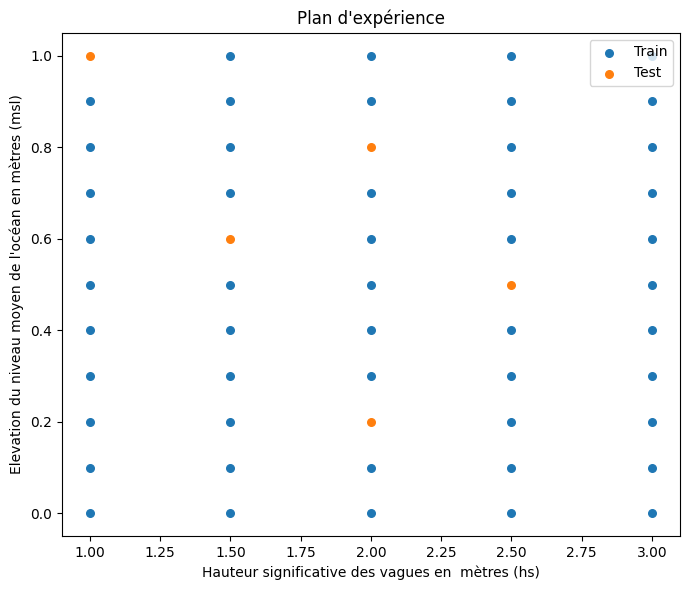

In [19]:
plt.figure(figsize=(7,6))
plt.scatter(x_train_filtered[:,0],x_train_filtered[:,1],label="Train",s=30)
plt.scatter(x_test[:,0],x_test[:,1],label="Test",s=30)
plt.xlabel("Hauteur significative des vagues en  mètres (hs)")
plt.ylabel("Elevation du niveau moyen de l'océan en mètres (msl)")
plt.title("Plan d'expérience")
plt.legend()
plt.tight_layout()
plt.show()

## On récupère les sorties :
On utilise cette fonction pour récuperer les données présente dans un dossier

In [20]:
def Recuperer_data(base_folder,x):
    # On récupère le nombre de cellules terrestres
    cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",dtype=">f8").reshape(-1, 5)
    n_cells = cell_info.shape[0]
    id_gmsh = cell_info[:, 0].astype(int)-1  

    y_H_max = []
    y_H_moyenne = []

    for hs,msl in x:
            
            folder_name = f"run_msl_{msl:.1f}_hs_{hs:.1f}"
            file_path = os.path.join(base_folder, folder_name, "scattered_map_final.bin")

            if not os.path.exists(file_path):
                print("⚠️ Fichier manquant :", file_path)
                Hmax = np.full(n_cells, np.nan)
                Hmoyenne = np.full(n_cells, np.nan)
            else:
                # Lecture correcte du binaire (big-endian float64)
                data = np.fromfile(file_path, dtype=">f8").reshape(-1, 3)

                # Colonnes : [ID_global, Hmax_T, Hmean_T]
                Hmax = data[:, 1]   # Hauteur max
                Hmoyenne = data[:, 2]  # Hauteur moyenne

            y_H_max.append(Hmax)
            y_H_moyenne.append(Hmoyenne)
    
    y_H_max = np.array(y_H_max)
    y_H_moyenne = np.array(y_H_moyenne)

    return y_H_max,y_H_moyenne

On commence par les y_train qu'on récupère dans le dossier data_malo_GP/Train

In [21]:
y_train_H_max,y_train_H_moyenne = Recuperer_data("data_malo_GP/Train",x_train)
print("Taille de y_train_Hmax :", y_train_H_max.shape)
print("Taille de y_train_H_moyenne :", y_train_H_moyenne.shape)

Taille de y_train_Hmax : (50, 488290)
Taille de y_train_H_moyenne : (50, 488290)


Puis on récupère les y_test qu'on récupère dans le dossier data_malo_GP/Test

In [22]:
y_test_H_max,y_test_H_moyenne = Recuperer_data("data_malo_GP/Test",x_test)

print("Taille de y_test_H_max :", y_test_H_max.shape)
print("Taille de y_test_H_moyenne :", y_test_H_moyenne.shape)

Taille de y_test_H_max : (5, 488290)
Taille de y_test_H_moyenne : (5, 488290)


On choisit de regarder la hauteur d'eau max pour la suite

In [23]:
y_train = y_train_H_max #y_train_H_moyenne
y_test = y_test_H_max   #y_test_H_moyenne

In [24]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma
param = [theta, sigma]

kernel = gpflow.kernels.SquaredExponential(lengthscales=param[0], variance=param[1]**2) + gpflow.kernels.White(variance=1e-6)

In [25]:
# ACP ondelettes
ACP_wave = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p=0.9999,J=2)
ACP_wave.train(x_train,y_train,kernel_fn=kernel,verbose=True)

Nombre de coefficients conservés pour l'ACP : 218002

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée 

On regarde l'erreur si on prédit sur les données d'entrainement

In [26]:
Y_train_reconstruct_ACP_wave = ACP_wave.predict(x_train)  # On prédit sur les données d'entraînement pour vérifier la reconstruction

mse_ACP = np.mean((y_train - Y_train_reconstruct_ACP_wave)**2)
print("MSE ACP sur données d'entraînement :", mse_ACP)

Prédiction en cours...
MSE ACP sur données d'entraînement : 0.002955039512081431


Et on regarde sur les données de test

In [27]:
Y_test_reconstruct_ACP_wave = ACP_wave.predict(x_test)  

mse_ACP = np.mean((y_test - Y_test_reconstruct_ACP_wave)**2)
print("MSE ACP sur données de test :", mse_ACP)

Prédiction en cours...
MSE ACP sur données de test : 0.007127873422254665


In [28]:
def plot_map(H_true, H_pred):
    mesh = pv.read("data_malo_GP/gmsh_mapping.vtk")
    cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",dtype=">f8").reshape(-1, 5)
    id_gmsh = cell_info[:, 0].astype(int) - 1  

    vtk_2_gmsh = mesh.cell_data["gmsh_cell_id"].astype(int) - 1
    gmsh_2_vtk = np.empty_like(vtk_2_gmsh)
    gmsh_2_vtk[vtk_2_gmsh] = np.arange(len(vtk_2_gmsh))
    id_vtk = gmsh_2_vtk[id_gmsh]

    submesh = mesh.extract_cells(id_vtk)

    mesh_true = submesh.copy()
    mesh_true.cell_data["H"] = H_true

    mesh_pred = submesh.copy()
    mesh_pred.cell_data["H"] = H_pred

    # Plot
    plotter = pv.Plotter(shape=(1, 2))

    # Subplot 0 : vrai
    plotter.subplot(0, 0)
    plotter.add_mesh(mesh_true, scalars="H", clim=[0, 1], cmap="coolwarm")
    plotter.view_xy()
    plotter.add_title("Sortie réelle", font_size=12)

    # Subplot 1 : prédit
    plotter.subplot(0, 1)
    plotter.add_mesh(mesh_pred, scalars="H", clim=[0, 1], cmap="coolwarm")
    plotter.view_xy()
    plotter.add_title("Reconstruction", font_size=12)

    # Ajouter une seule colorbar commune
    plotter.add_scalar_bar(title="H", n_labels=5, vertical=True, width=0.08, height=0.8, position_x=0.92, position_y=0.1)

    plotter.show()

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


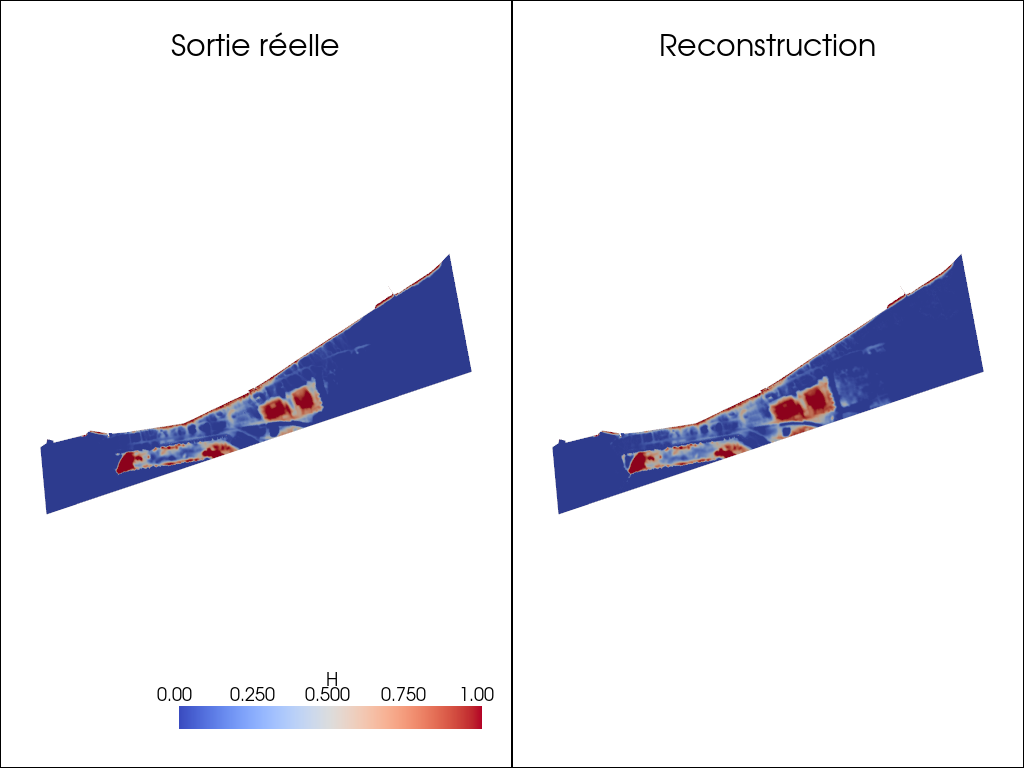

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


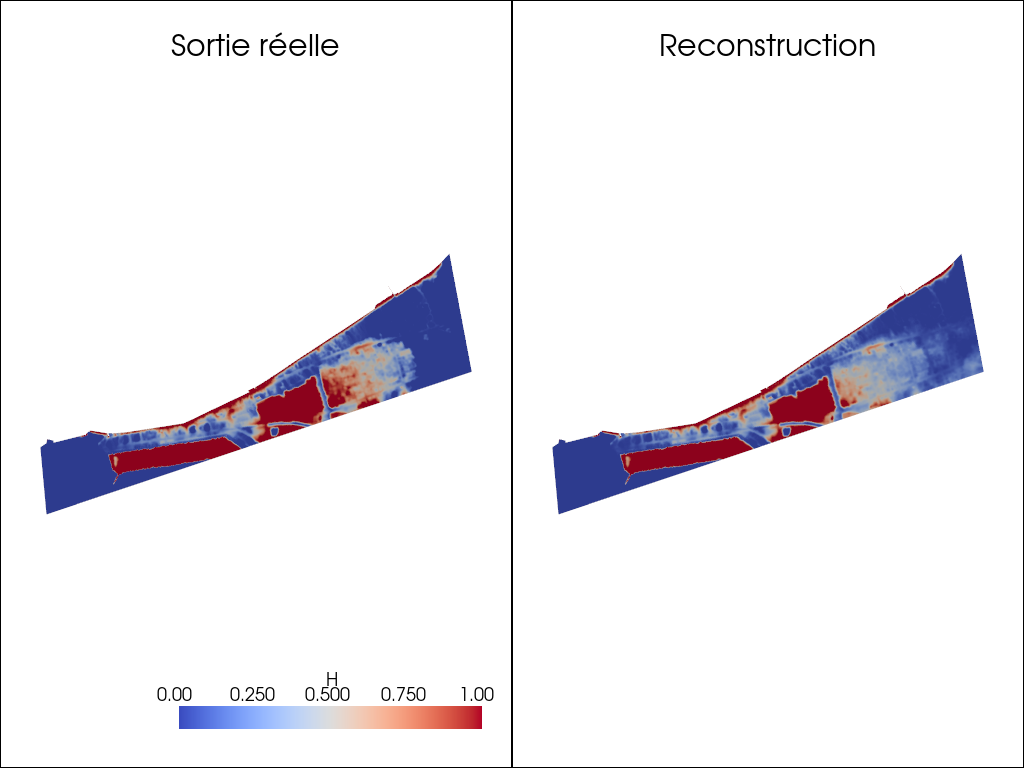

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


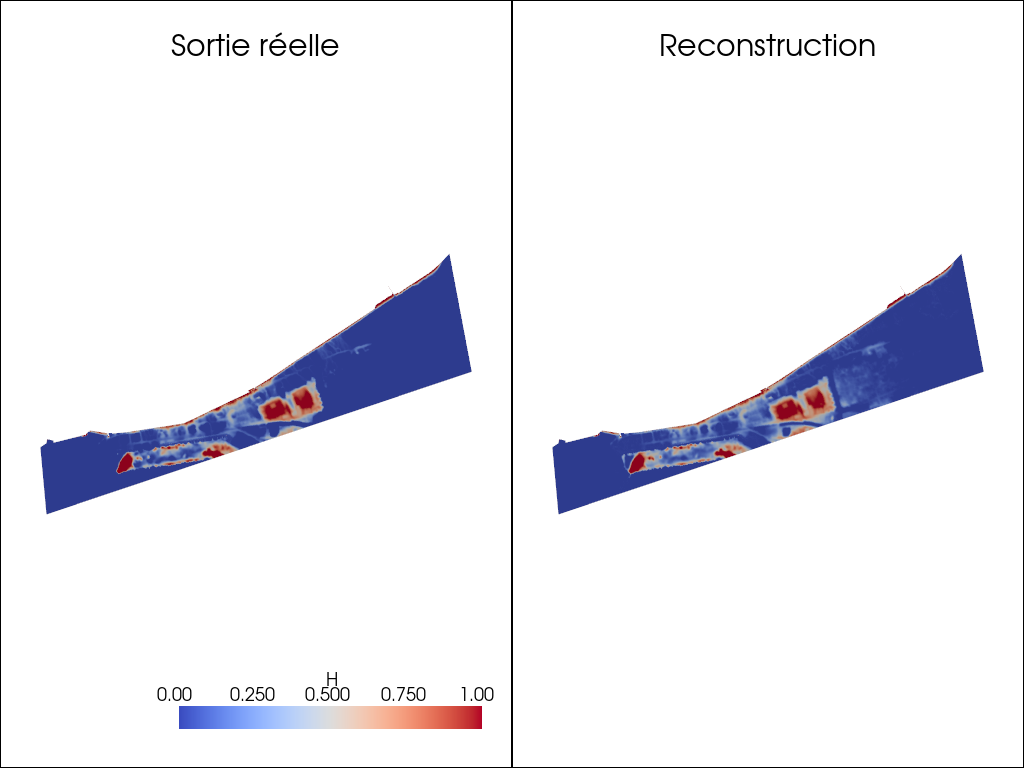

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


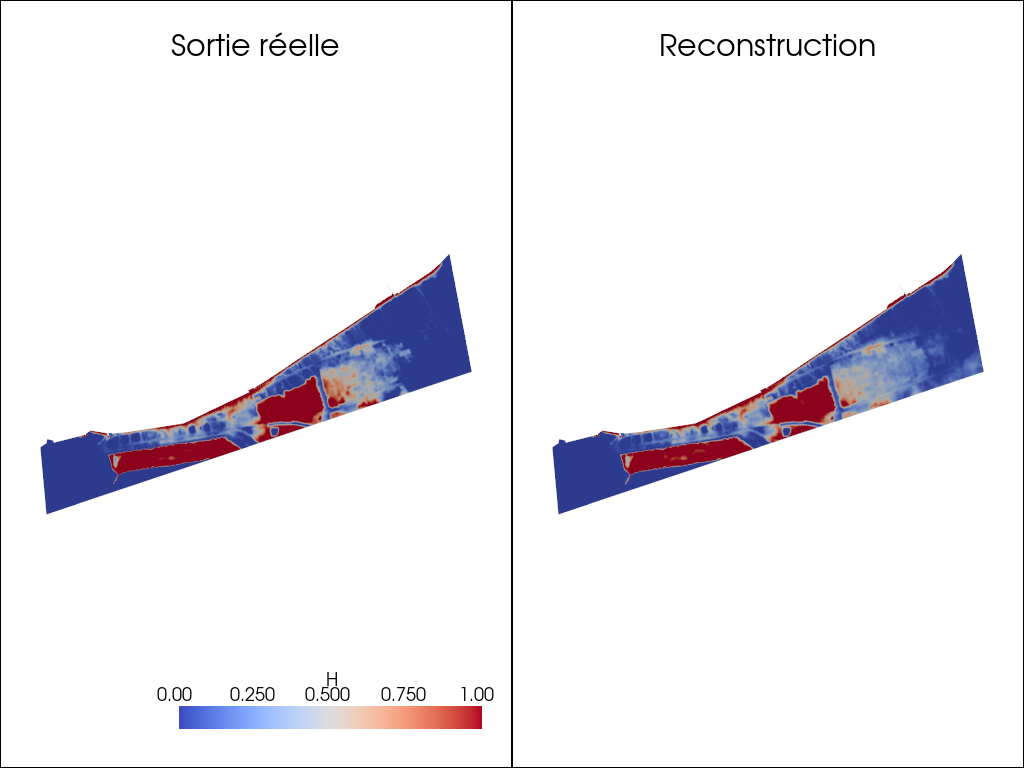

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


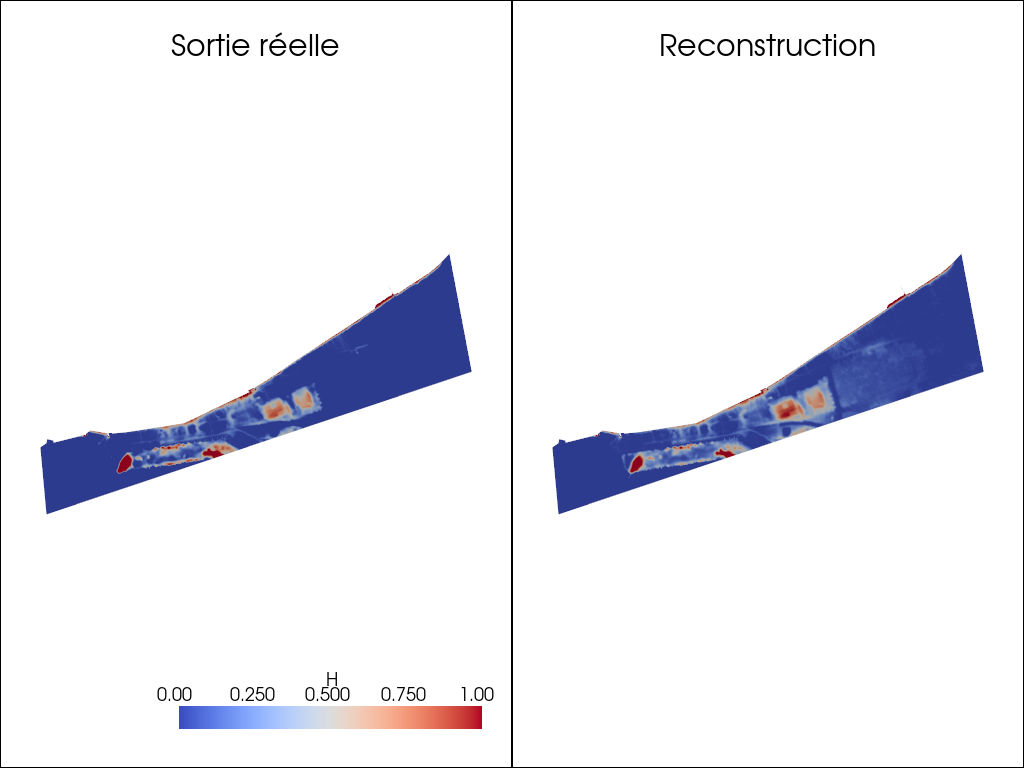

In [29]:
for i in range(5):
    plot_map(y_test[i,:],Y_test_reconstruct_ACP_wave[i,:])